In [1]:
%reset
%load_ext autoreload
%autoreload 2

import numpy as np
import seaborn as sns
from scipy.stats import norm, multivariate_normal, gengamma
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D, get_test_data
from matplotlib import cm
import matplotlib.gridspec as gridspec

from pdf_computer import pdfComputer
from logistic_network import Logistic
from info import info

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# Settings for plot
plt.rcParams["figure.figsize"] = (20,8)
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
# PDF estimation method
approach = 'kde_cuda'
# Function for calculating the PDF difference (RMSE)
def rmse(pdf1, pdf2):
    return np.sqrt(((pdf1 - pdf2) ** 2).mean())

In [3]:
# 1D - gamma distribution
shape, rate = 7.5, 1.
xmin, xmax   = 0.001, 20.
nsamples_set = np.arange(2, 2000, 10)
nestimate    = 50
nsample_cat  = nsamples_set.size
est_pts      = np.linspace(xmin, xmax, nestimate)
pdf_est_set  = np.zeros([nestimate, nsample_cat])
H_set        = np.zeros(nsample_cat)
pdfsolver    = pdfComputer(ndim=1, approach=approach, bandwidth='silverman')
# Calculate the true pdf at the locations to be estimated and the true entropy
pdf_true = gengamma.pdf(est_pts, shape, rate)
pdf_true = pdf_true/pdf_true.sum()
H_true   = info(pdf_true).hx
# Calculate the estimated pdf and the entropy
for i in range(nsample_cat):
    nsample = nsamples_set[i]
    samples = np.random.gamma(shape=shape, scale=1./rate, size=nsample)
    _, pdf_est, _ = pdfsolver.computePDF(samples[:,np.newaxis], nbins=[nestimate], limits=[[xmin,xmax]], atomCheck=True)
    H       = info(pdf_est).hx
    pdf_est_set[:, i] = pdf_est
    H_set[i]   = H
    
# Calculate the rmse of each estimated pdf set and entropy
rmse_set_pdf = map(lambda i: rmse(pdf_true, pdf_est_set[:, i]), range(nsample_cat))
# rmse_set_H = map(lambda i: rmse(H_true, H_set[i]), range(nsample_cat))
H_diff = H_true - H_set

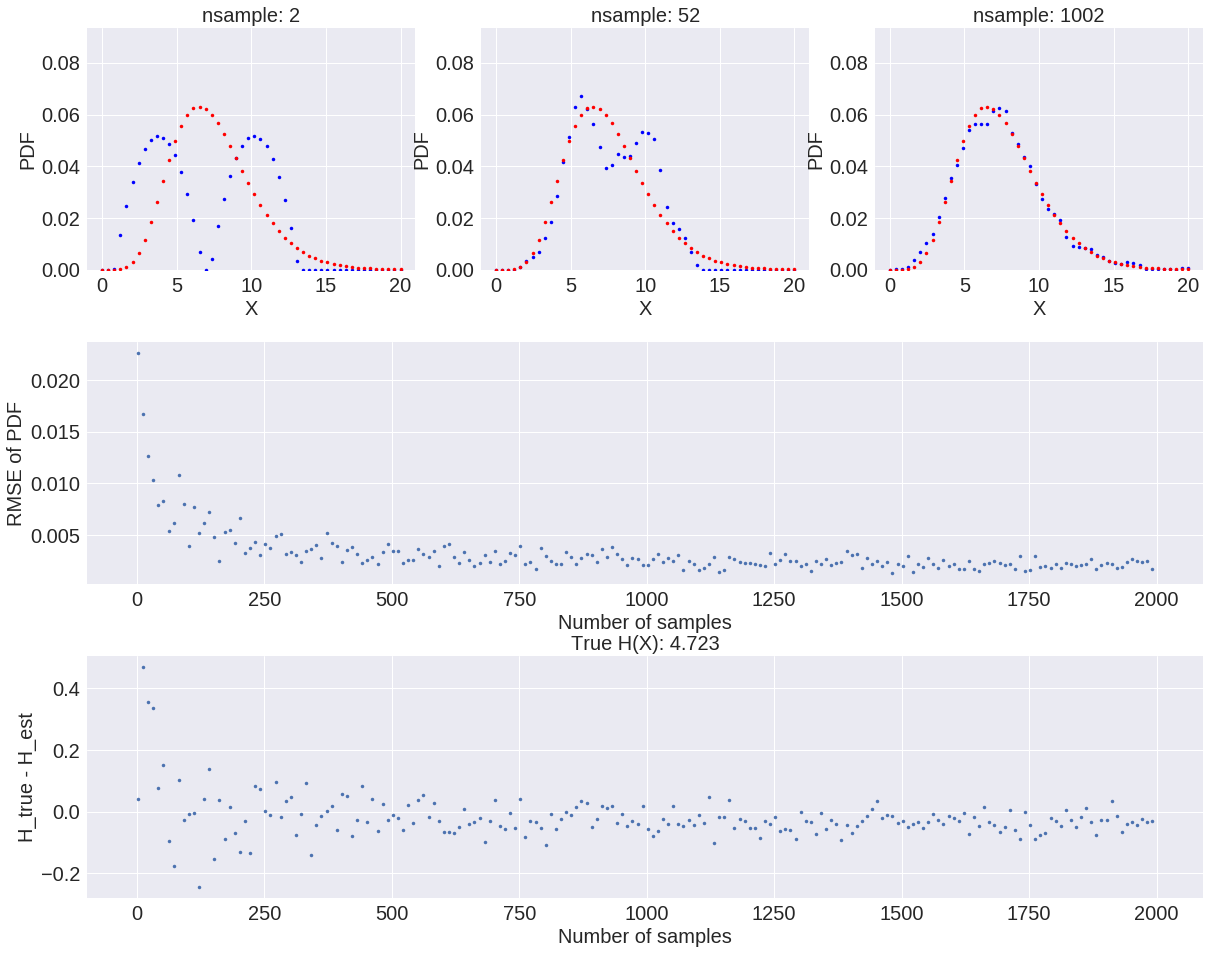

In [4]:
# Plot -- 1D
plt.rcParams["figure.figsize"] = (20,16)

gs = gridspec.GridSpec(3, 3)
gs.update(wspace=0.2, hspace=0.3)

i = 0
ax = plt.subplot(gs[0, 0])
ax.plot(est_pts, pdf_est_set[:, i], '.b')
ax.plot(est_pts, pdf_true, '.r')
ax.set_ylim([0, pdf_est_set.max()])
ax.set_xlabel('X')
ax.set_ylabel('PDF')
ax.set_title('nsample: %d' % nsamples_set[i])

i = 5
ax = plt.subplot(gs[0, 1])
ax.plot(est_pts, pdf_est_set[:, i], '.b')
ax.plot(est_pts, pdf_true, '.r')
ax.set_ylim([0, pdf_est_set.max()])
ax.set_xlabel('X')
ax.set_ylabel('PDF')
ax.set_title('nsample: %d' % nsamples_set[i])

i = 100
ax = plt.subplot(gs[0, 2])
ax.plot(est_pts, pdf_est_set[:, i], '.b')
ax.plot(est_pts, pdf_true, '.r')
ax.set_ylim([0, pdf_est_set.max()])
ax.set_xlabel('X')
ax.set_ylabel('PDF')
ax.set_title('nsample: %d' % nsamples_set[i])

ax = plt.subplot(gs[1, :])
ax.plot(nsamples_set, rmse_set_pdf, '.')
ax.set_xlabel('Number of samples')
ax.set_ylabel('RMSE of PDF')

ax = plt.subplot(gs[2, :])
ax.plot(nsamples_set, H_diff, '.')
ax.set_xlabel('Number of samples')
ax.set_ylabel('H_true - H_est')
ax.set_title('True H(X): %.3f' % H_true)

plt.show()

In [5]:
# 2D - logistic forcing
# x1(t) = f(x1(t-1))
# x2(t) = f(x1(t-3))
# f(x) = ax(1-x) (a=4)
##
# Parameters for noise parameters
noiseType = 'exclusive'
noiseDist = 'uniform'
noisePara = [1, 0, 1]
# Parameters for the relationship between variables
n    = 2
adjM = np.array([[1, 0], [1, 0]])
lagM = np.array([[1, 0], [3, 0]])
# Parameters for simulation
nstep = 20000
# Parameters for PDF estimating
xmin, xmax   = 0., 1.
ymin, ymax   = 0., 1.
nsamples_set = np.arange(5, 20000, 100)
nsample_cat  = nsamples_set.size
nx,ny        = 50, 50
pdf_est_set  = np.zeros([nx, ny, nsample_cat])
I_set        = np.zeros(nsample_cat)
xcoord, ycoord = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
xpts, ypts   = np.meshgrid(xcoord, ycoord, indexing='ij')
pdfsolver    = pdfComputer(ndim=2, approach=approach, bandwidth='silverman')
# Initialize the logistic equations
logistic = Logistic(n, adjM, lagM, noiseType, noiseDist, noisePara)
# Calculate the true pdf at the locations to be estimated and the true mutual information
x_set = logistic.simulate(nstep)
x1, x2 = x_set[0,:], x_set[1,:]
samples_true = np.array([x1[:-3], x2[3:]]).T
_, pdf_true, _ = pdfsolver.computePDF(samples_true, nbins=[nx,ny], limits=[[xmin,xmax],[ymin,ymax]], atomCheck=True)
I_true = info(pdf_true).ixy
# Calculate the estimated pdf and mutual information
for i in range(nsample_cat):
    nsample = nsamples_set[i]
    x_set   = logistic.simulate(nsample)
    x1, x2  = x_set[0,:], x_set[1,:]
    samples = np.array([x1[:-3], x2[3:]]).T
    _, pdf_est, _ = pdfsolver.computePDF(samples, nbins=[nx,ny], limits=[[xmin,xmax],[ymin,ymax]], atomCheck=True)
    I       = info(pdf_est).ixy
    pdf_est_set[:, :, i] = pdf_est
    I_set[i] = I
# Calculate the rmse for each estimated pdf set and mutual information
rmse_set_pdf = map(lambda i: rmse(pdf_true, pdf_est_set[:, :, i]), range(nsample_cat))
# rmse_set_I = map(lambda i: rmse(I_true, I_set[i]), range(nsample_cat))
I_diff = I_true - I_set

info.py:181: RuntimeWarning: invalid value encountered in divide
  ypdfs_x_log, ypdfs_x = np.ma.log(xypdfs/xpdfs), np.ma.divide(xypdfs, xpdfs)
info.py:211: RuntimeWarning: invalid value encountered in divide
  ixypdf_log = np.ma.log(pdfs/(xpdfs*ypdfs))


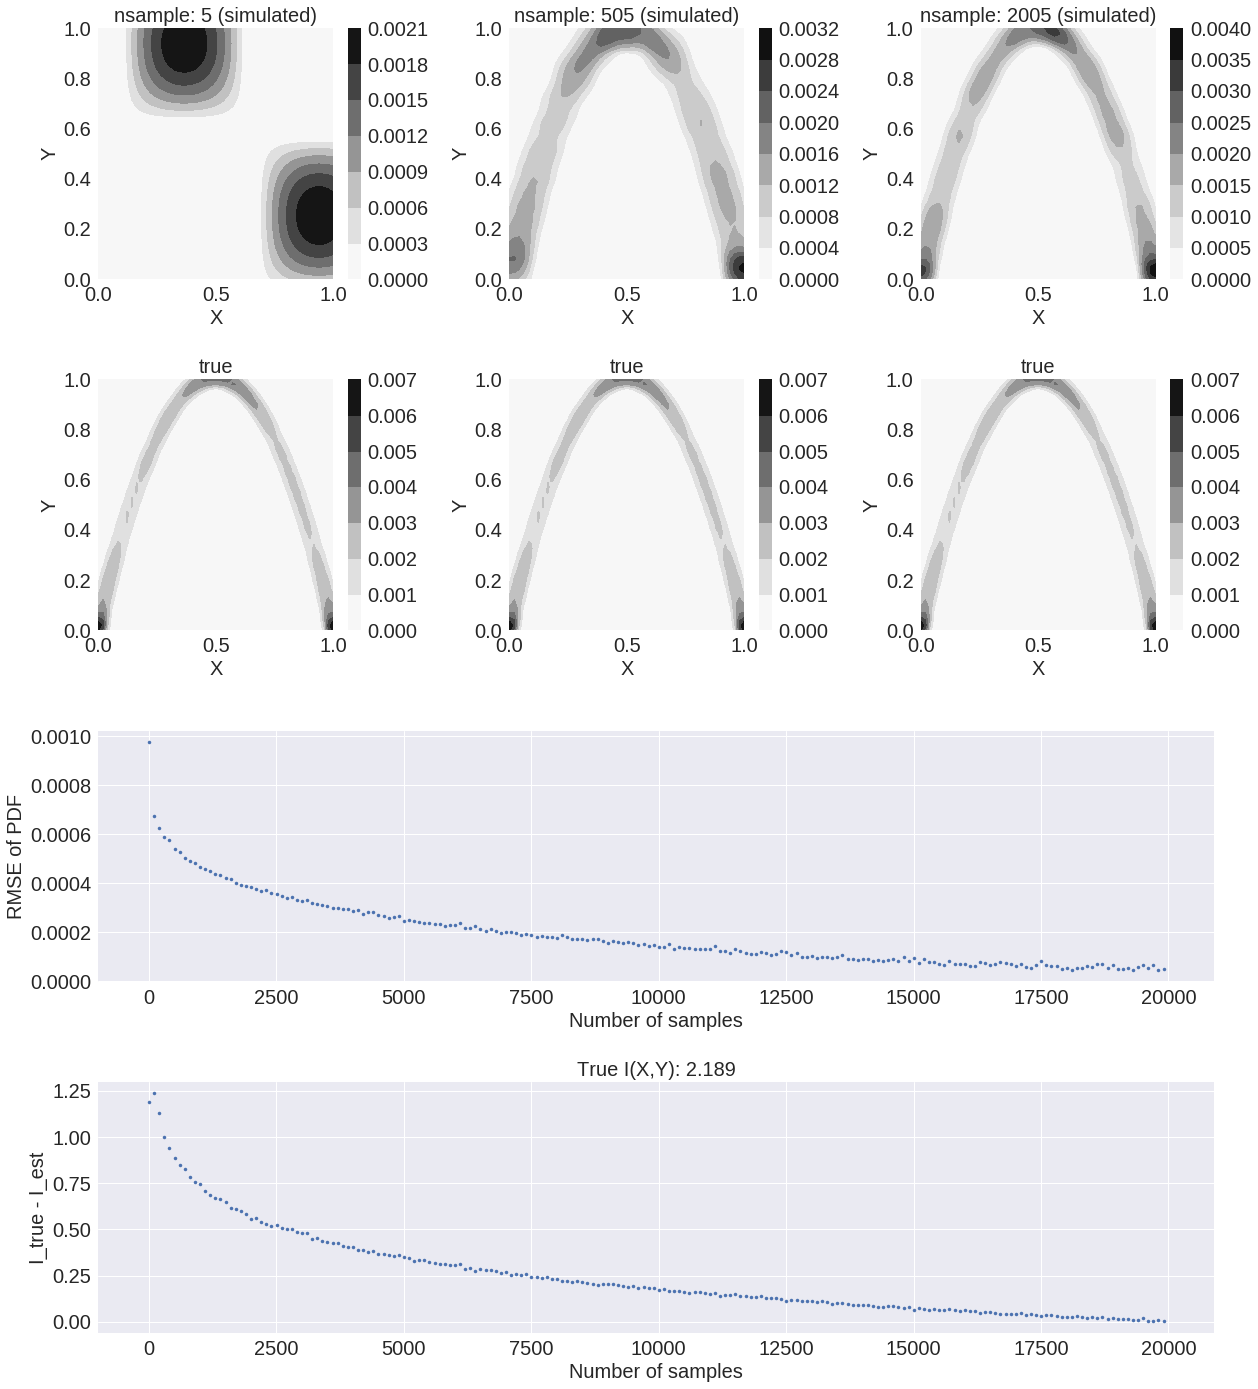

In [6]:
# Plot -- 2D
plt.rcParams["figure.figsize"] = (20,24)

gs = gridspec.GridSpec(4, 3)
gs.update(wspace=0.4, hspace=0.4)

i = 0
ax1, ax2 = plt.subplot(gs[0, 0]), plt.subplot(gs[1, 0])
cs = ax1.contourf(xpts, ypts, pdf_est_set[:, :, i])
plt.colorbar(cs, ax=ax1)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('nsample: %d (simulated)' % nsamples_set[i])
cs = ax2.contourf(xpts, ypts, pdf_true)
plt.colorbar(cs, ax=ax2)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('true' % nsamples_set[i])


i = 5
ax1, ax2 = plt.subplot(gs[0, 1]), plt.subplot(gs[1, 1])
cs = ax1.contourf(xpts, ypts, pdf_est_set[:, :, i])
plt.colorbar(cs, ax=ax1)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('nsample: %d (simulated)' % nsamples_set[i])
cs = ax2.contourf(xpts, ypts, pdf_true)
plt.colorbar(cs, ax=ax2)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('true' % nsamples_set[i])

i = 20
ax1, ax2 = plt.subplot(gs[0, 2]), plt.subplot(gs[1, 2])
cs = ax1.contourf(xpts, ypts, pdf_est_set[:, :, i])
plt.colorbar(cs, ax=ax1)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('nsample: %d (simulated)' % nsamples_set[i])
cs = ax2.contourf(xpts, ypts, pdf_true)
plt.colorbar(cs, ax=ax2)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('true' % nsamples_set[i])

ax = plt.subplot(gs[2, :])
ax.plot(nsamples_set, rmse_set_pdf, '.')
ax.set_xlabel('Number of samples')
ax.set_ylabel('RMSE of PDF')

ax = plt.subplot(gs[3, :])
ax.plot(nsamples_set, I_diff, '.')
ax.set_xlabel('Number of samples')
ax.set_ylabel('I_true - I_est')
ax.set_title('True I(X,Y): %.3f' % I_true)

plt.show()

In [7]:
# 3D - logistic forcing
# x1(t) = f(x1(t-1))
# x2(t) = f(x1(t-3))
# f(x) = ax(1-x) (a=4)
##
# Parameters for noise parameters
noiseType = 'exclusive'
noiseDist = 'uniform'
noisePara = [1, 0, 1]
# Parameters for the relationship between variables
n    = 2
adjM = np.array([[1, 0], [1, 0]])
lagM = np.array([[1, 0], [3, 0]])
# Parameters for simulation
nstep = 20000
# Parameters for PDF estimating
xmin, xmax   = 0., 1.
ymin, ymax   = 0., 1.
zmin, zmax   = 0., 1.
nsamples_set = np.concatenate([np.arange(5,100,10), np.arange(100, 20000, 100)])
nsample_cat  = nsamples_set.size
nx, ny, nz   = 50, 50, 50
pdf_est_set  = np.zeros([nx, ny, nz, nsample_cat])
t_set        = np.zeros(nsample_cat)
xcoord, ycoord = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
xpts, ypts   = np.meshgrid(xcoord, ycoord, indexing='ij')
pdfsolver    = pdfComputer(ndim=3, approach=approach, bandwidth='silverman')
# Initialize the logistic equations
logistic = Logistic(n, adjM, lagM, noiseType, noiseDist, noisePara)
# Calculate the true pdf at the locations to be estimated and the true mutual information
x_set = logistic.simulate(nstep)
x1, x2 = x_set[0,:], x_set[1,:], 
samples_true = np.array([x1[1:-2], x1[:-3], x2[3:]]).T
_, pdf_true, _ = pdfsolver.computePDF(samples_true, nbins=[nx,ny,nz], limits=[[xmin,xmax],[ymin,ymax],[zmin,zmax]], atomCheck=True)
t_true = info(pdf_true).ixz_y
# Calculate the estimated pdf and mutual information
for i in range(nsample_cat):
    nsample = nsamples_set[i]
    x_set   = logistic.simulate(nsample)
    x1, x2  = x_set[0,:], x_set[1,:]
    samples = np.array([x1[1:-2], x1[:-3], x2[3:]]).T
    _, pdf_est, _ = pdfsolver.computePDF(samples, nbins=[nx,ny,nz], limits=[[xmin,xmax],[ymin,ymax],[zmin,zmax]], atomCheck=True)
    t       = info(pdf_est).ixz_y
    pdf_est_set[:, :, :, i] = pdf_est
    t_set[i] = t
# Calculate the rmse for each estimated pdf set and mutual information
rmse_set_pdf = map(lambda i: rmse(pdf_true, pdf_est_set[:, :, :, i]), range(nsample_cat))
# rmse_set_I = map(lambda i: rmse(I_true, I_set[i]), range(nsample_cat))
t_diff = t_true - t_set

info.py:247: RuntimeWarning: invalid value encountered in divide
  txypdf_log = np.ma.log(pdfs*factor1/(factor2*factor3))
pdf_computer.py:607: RuntimeWarning: invalid value encountered in divide
  pdf = pdf/pdf.sum()


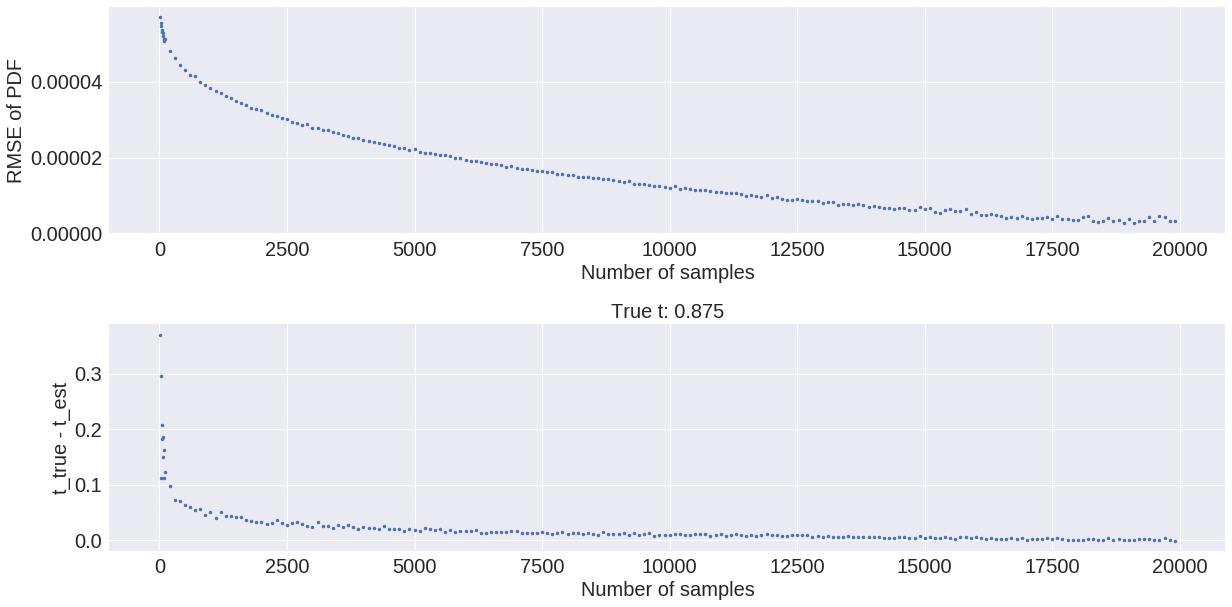

In [8]:
# Plot -- 3D
plt.rcParams["figure.figsize"] = (20,10)

gs = gridspec.GridSpec(2, 1)
gs.update(wspace=0.4, hspace=0.4)

ax = plt.subplot(gs[0, 0])
ax.plot(nsamples_set, rmse_set_pdf, '.')
ax.set_xlabel('Number of samples')
ax.set_ylabel('RMSE of PDF')

ax = plt.subplot(gs[1, 0])
ax.plot(nsamples_set, t_diff, '.')
ax.set_xlabel('Number of samples')
ax.set_ylabel('t_true - t_est')
ax.set_title('True t: %.3f' % t_true)

plt.show()